In [1]:
import tensorflow as tf
import numpy as np
AUTO = tf.data.experimental.AUTOTUNE
GCS_OUTPUT = 'gs://cloudfire_lyrical-edition-273206/fire_dataset/tfrecords-augmented_dataset-9/'  # prefix for output file names

TARGET_SIZE = [256, 256]


def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar

        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label": tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size": tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)  # a certain number of floats
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)

    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding

    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])

    class_num = example['class']

    label = example['label']
    height = example['size'][0]
    width = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, label


# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTO)

In [2]:
dataset4

<ParallelMapDataset shapes: ((256, 256, 3), ()), types: (tf.uint8, tf.string)>

In [29]:
for image, class_num, label, height, width, one_hot_class in dataset4.take(100):
    print("Image shape {}, {}x{} px, class={} ({:>10}, {})".format(image.numpy().shape, width, height, class_num,label.numpy().decode('utf8'),one_hot_class))

Image shape (256, 256, 3), 256x256 px, class=1 (    Normal, [0. 1.])
Image shape (256, 256, 3), 256x256 px, class=1 (    Normal, [0. 1.])
Image shape (256, 256, 3), 256x256 px, class=1 (    Normal, [0. 1.])
Image shape (256, 256, 3), 256x256 px, class=0 (      Fire, [1. 0.])
Image shape (256, 256, 3), 256x256 px, class=1 (    Normal, [0. 1.])
Image shape (256, 256, 3), 256x256 px, class=1 (    Normal, [0. 1.])
Image shape (256, 256, 3), 256x256 px, class=1 (    Normal, [0. 1.])
Image shape (256, 256, 3), 256x256 px, class=0 (      Fire, [1. 0.])
Image shape (256, 256, 3), 256x256 px, class=0 (      Fire, [1. 0.])
Image shape (256, 256, 3), 256x256 px, class=0 (      Fire, [1. 0.])
Image shape (256, 256, 3), 256x256 px, class=1 (    Normal, [0. 1.])
Image shape (256, 256, 3), 256x256 px, class=0 (      Fire, [1. 0.])
Image shape (256, 256, 3), 256x256 px, class=0 (      Fire, [1. 0.])
Image shape (256, 256, 3), 256x256 px, class=1 (    Normal, [0. 1.])
Image shape (256, 256, 3), 256x256

In [4]:
from matplotlib import pyplot as plt
CLASSES = ['Fire', 'Normal']

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels
'''
def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)  # one-hot to class number
    correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct
'''
def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
    subplot=331
    plt.figure(figsize=(13,13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        title = CLASSES[np.argmax(labels[i], axis=-1)]
        subplot = display_one_flower(image, title, subplot)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()  

    '''
def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
    '''


In [ ]:
display_9_images_from_dataset(dataset4)

In [9]:
from matplotlib import pyplot as plt
CLASSES = ['Fire', 'Normal']

def show_batch(numpy_images, numpy_labels):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(numpy_images[n])
        plt.title(CLASSES[numpy_labels[n]==1][0].title())
        plt.axis('off')

In [10]:
def dataset_to_numpy_util(dataset4,N):
    dataset = dataset4.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy() 
        show_batch(numpy_images, numpy_labels)      

IndexError: index 11 is out of bounds for axis 0 with size 11

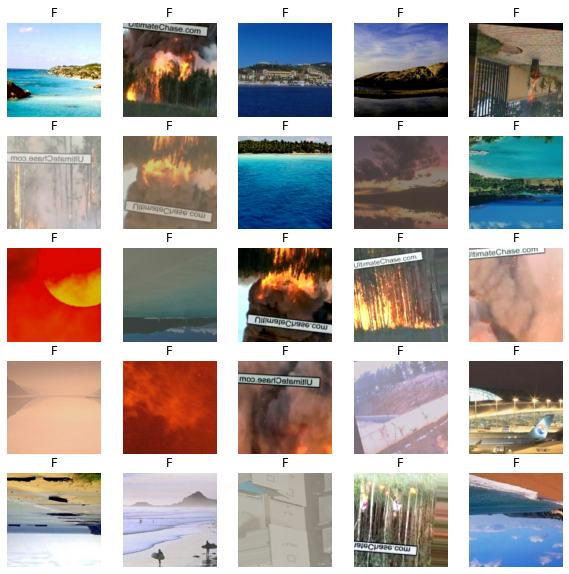

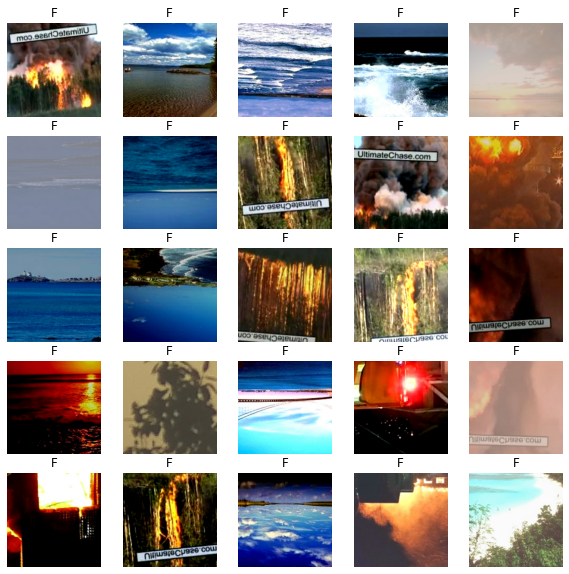

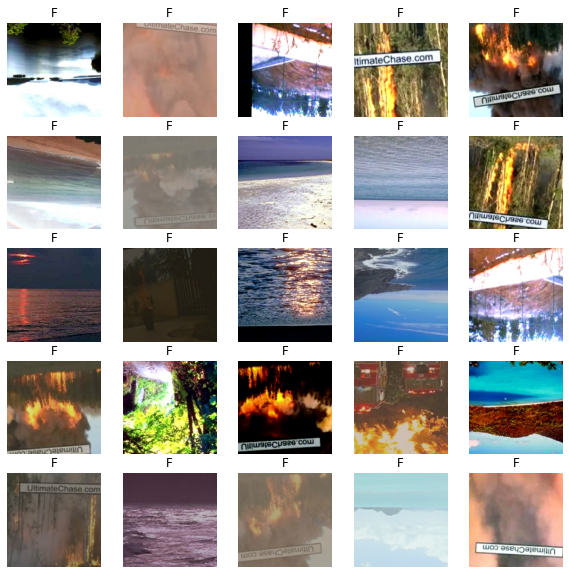

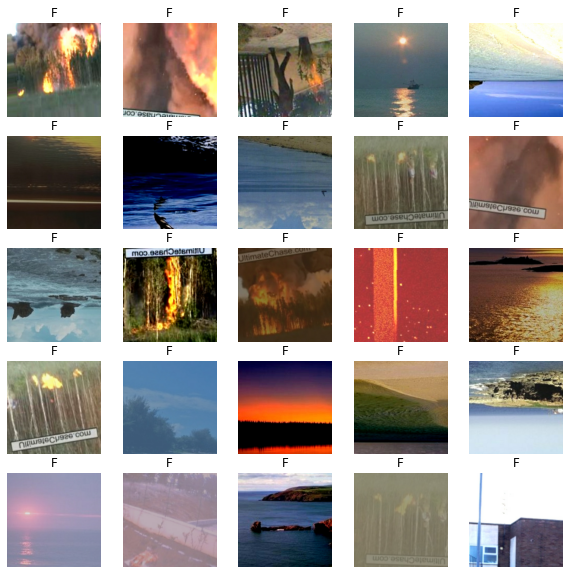

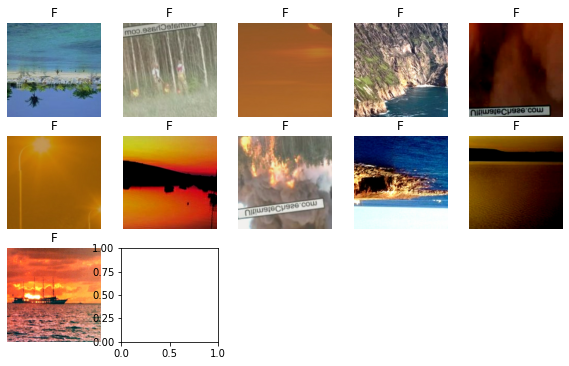

In [11]:
dataset_to_numpy_util(dataset4,50) 